<a href="https://colab.research.google.com/github/alexdel1/HackGoogleAI/blob/main/UBernTest2over2_Delode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alexandre Delode
##Research Positions in Machine Learning and Computer Vision
###June 19, 2024

### Task  2 - Second part

Import the required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

Create train/test sets

In [7]:
# Load CIFAR-10 dataset
(x_train, _), (_, _) = cifar10.load_data()

# Take 100 images for the task
images = x_train[:100]
images_test = x_train[100:200]

The data augmentation , see first file for some exemples

In [9]:
def data_augmentation(images):
    # Function to perform data augmentation
    data_aug = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.GaussianNoise(0.1)
    ])
    # Apply augmentation to each image
    augmented_images = np.array([tf.cast(data_aug(image), tf.float32) / 255.0 for image in images])

    return augmented_images

# Augment images
augmented_images = data_augmentation(images)

Some basic values about VGG16 for the feature extraction.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np

input_shape = (32, 32, 3)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
features1 = base_model(tf.expand_dims(images[0], axis=0))
print(features1.shape)
print(tf.reduce_min(features1))
print(tf.reduce_max(features1))
features2 = base_model(tf.expand_dims(images[0], axis=0))
print(tf.reduce_min(features2))
print(tf.reduce_max(features2))


(1, 1, 1, 512)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(171.37624, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(171.37624, shape=(), dtype=float32)


The sender has the task to order the images. The features are extracted by VGG16. This ordering must be trainable in order to optimize the objective. The solution of matrix multiplication with a learnable vector has been chosen. For the backpropagation process, the order choice must be soft. It is done by a sigmoid function with a scaling factor.

In [7]:
class SenderModel(tf.keras.Model):
    def __init__(self):
        super(SenderModel, self).__init__()
        self.input1=layers.InputLayer(input_shape=(32,32,3))
        self.input2=layers.InputLayer(input_shape=(32,32,3))
        self.orderim = tf.Variable(tf.random.uniform(shape=(512,), minval=-1.0, maxval=1.0, dtype=tf.float32))
        self.base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        for layer in self.base_model.layers:
            layer.trainable = False

    def call(self, x1 , x2):
        x1 = self.input1(x1)
        x2 = self.input2(x2)

        features1 = self.base_model(x1)
        features2 = self.base_model(x2)

        # Compute scalar product (dot product)
        score1 = tf.reduce_sum(self.orderim * features1, axis=[1, 2, 3], keepdims=True)
        score2 = tf.reduce_sum(self.orderim * features2, axis=[1, 2, 3], keepdims=True)

        # Differentiable comparison
        comparison = tf.keras.activations.sigmoid((score1 - score2)*10)
        return comparison


In [8]:
# Build and summarize the sender
Sender = SenderModel()
input_sender_img1 = tf.keras.Input(shape=(32,32,3))
input_sender_img2 = tf.keras.Input(shape=(32,32,3))
output_sender_ord = Sender(input_sender_img1,input_sender_img2)
sender_model = Model((input_sender_img1,input_sender_img2), output_sender_ord)
sender_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
sender_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sender_model (SenderModel)  (None, 1, 1, 1)              1471520   ['input_6[0][0]',             
                                                          0          'input_7[0][0]']             
                                                                                                  
Total params: 14715200 (56.13 MB)
Trainable params: 512 (2.00 KB)
Non-trainable params: 147146

Some tests to check the almost 0-1 output.

In [13]:
sender_model((tf.expand_dims(images[0], axis=0),tf.expand_dims(images[1], axis=0)))

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.]]]], dtype=float32)>

In [14]:
sender_model((tf.expand_dims(images[1], axis=0),tf.expand_dims(images[0], axis=0)))

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[1.]]]], dtype=float32)>

In [16]:
sender_model((tf.expand_dims(images[1], axis=0),tf.expand_dims(images[98], axis=0)))

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.]]]], dtype=float32)>

The embedding is done like the assigment description with two trainable vectors. As the output of the sender is almost 0-1, the output of the embedding model is almost xi1 or xi2.

In [17]:
embed_dim=512

class EmbeddingModel(tf.keras.Model):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.xi_0 = tf.Variable(tf.random.uniform(shape=(embed_dim,), minval=-1.0, maxval=1.0, dtype=tf.float32))
        self.xi_1 = tf.Variable(tf.random.uniform(shape=(embed_dim,), minval=-1.0, maxval=1.0, dtype=tf.float32))
    def call(self, x):
        x = tf.reshape(x, [])
        y=(1-x)*self.xi_0 + x*self.xi_1

        return y

# Build and summarize the embedder
Embedding_1 = EmbeddingModel()
input_emb_order = tf.keras.Input(shape=(1))
output_emb_vect = Embedding_1(input_emb_order)
emb_model = Model(input_emb_order, output_emb_vect)
emb_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
emb_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_model (Embedding  (512,)                    1024      
 Model)                                                          
                                                                 
Total params: 1024 (4.00 KB)
Trainable params: 1024 (4.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The receiver is a neural network classifier. The inputs are the concatenation of the features of the 2 images and the vector xi1 or xi2. The sigmoid output is a probability of the transposition image.

In [19]:
class ReceiverModel(tf.keras.Model):
    def __init__(self):
        super(ReceiverModel, self).__init__()
        self.input1=layers.InputLayer(input_shape=(32,32,3))
        self.input2=layers.InputLayer(input_shape=(32,32,3))
        self.reshape = layers.Reshape((1, 1, embed_dim)) # Reshape layer to match CNN output
        # Initialize VGG16
        self.base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        for layer in self.base_model.layers:
            layer.trainable = False
        self.normalize = layers.LayerNormalization(axis=-1)
        self.concat = layers.Concatenate()
        self.dense1=layers.Dense(256, activation='relu')
        self.drop=layers.Dropout(0.2)
        self.dense2=layers.Dense(128, activation='relu') # Output scalar value centered to 0
        self.dense3=layers.Dense(1, name="outputs", activation='sigmoid') # Output scalar value centered to 0


    def call(self, x1 , x2, key):

        x1 = self.input1(x1)
        x2 = self.input2(x2)

        features1 = self.base_model(x1)
        features2 = self.base_model(x2)

        # Normalize features
        features1 = self.normalize(features1)
        features2 = self.normalize(features2)

        key = tf.reshape(key, (1, 1, embed_dim))
        key = self.reshape(key)
        combined = self.concat([features1, features2,key])
        combined = self.dense1(combined)
        combined = self.drop(combined)
        combined = self.dense2(combined)
        combined = self.dense3(combined)


        return combined

# Build and summarize the receiver
Receiver = ReceiverModel()
input_rec_imgaug1 = tf.keras.Input(shape=(32,32,3))
input_rec_imgaug2 = tf.keras.Input(shape=(32,32,3))
input_rec_key = tf.keras.Input(shape=( embed_dim))
output_rec_vect = Receiver(input_rec_imgaug1,input_rec_imgaug2,input_rec_key)
rec_model = Model((input_rec_imgaug1,input_rec_imgaug2,input_rec_key), output_rec_vect)
rec_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
rec_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 receiver_model_1 (Receiver  (1, 1, 1, 1)                 1514220   ['input_18[0][0]',            
 Model)                                                   9          'input_19[0][0]',      

Some methods for partial saving due to Colab disconnection.

In [20]:
import json
cumaccuracies=[]
cumlosses=[]
def save_to_json(lists_to_write, file_path):
  # Get the values of the lists from the global namespace
  data = {listname: globals()[listname] for listname in lists_to_write}

  # Save the data to a JSON file
  with open(file_path, 'w') as file:
    json.dump(data, file, indent=2)

def load_from_json(file_path):
  # Load the data from the JSON file
  with open(file_path, 'r') as file:
    data = json.load(file)

  return data

# Example usage
# Assuming you have lists named 'losses' and 'time' containing your data
lists_to_save = ['cumaccuracies', 'cumlosses']
save_path = '/content/my_data.json'  # Replace with your desired path

save_to_json(lists_to_save, save_path)

# Load the data back from the JSON file
loaded_data = load_from_json(save_path)

# Access the loaded data
print(loaded_data['cumaccuracies'])  # Access the 'losses' list
print(loaded_data['cumlosses'])   # Access the 'time' list


[]
[]


The training phase. Due to the problem complexity, a sample by sample approach with the gradient tape has been taken. The accuracies and the losses are saved in the loop. Every 1000 samples, the three models are saved.


The model is trained with shuffled input data.

In [23]:
import random
import itertools
# Get all possible pairs of indices using permutations
permutations_list = list(itertools.permutations(range(len(images)), 2))
# Randomly shuffle the list of pairs
random.shuffle(permutations_list)
print(permutations_list[:5])

[(17, 65), (51, 9), (8, 39), (86, 39), (96, 45)]


In [24]:
# Training configuration
optimizer = tf.keras.optimizers.Adam()
cumaccuracies=[]
cumlosses=[]

# Training loop
epochs = 1
k=0
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i1, i2 in permutations_list:
        k+=1
        print("sample",k)

        x1,x2=images[i1],images[i2]
        x1 = tf.convert_to_tensor(x1)
        x1 = tf.cast(x1 , dtype=tf.float32)
        x2 = tf.convert_to_tensor(x2)
        x2 = tf.cast(x2 , dtype=tf.float32)

        augmented_images_x1 = data_augmentation([x1])
        augmented_images_x2 = data_augmentation([x2])
        augmented_images_x1 = tf.convert_to_tensor(augmented_images_x1)
        augmented_images_x1 = tf.cast(augmented_images_x1 , dtype=tf.float32)
        augmented_images_x2 = tf.convert_to_tensor(augmented_images_x2)
        augmented_images_x2 = tf.cast(augmented_images_x2 , dtype=tf.float32)
        # Randomly stack augmented images
        p = np.random.binomial(1, 0.5)
        if p == 0:
            hat_x = ([augmented_images_x1[0], augmented_images_x2[0]])

        else:
            hat_x = ([augmented_images_x2[0], augmented_images_x1[0]])


        # Calculate true order p
        true_p = np.array([p], dtype=np.float32)
        true_p = tf.convert_to_tensor(true_p)
        # Train sender
        with tf.GradientTape() as tape:
            tape.watch(sender_model.trainable_variables)
            tape.watch(emb_model.trainable_variables)
            tape.watch(rec_model.trainable_variables)
            b_x = sender_model((tf.expand_dims(x1, axis=0),tf.expand_dims(x2, axis=0)))
            xi = emb_model(b_x)

            hat_p = rec_model((tf.expand_dims(hat_x[0],axis=0),tf.expand_dims(hat_x[1],axis=0), xi))

            loss = (hat_p-true_p)**2



        gradients = tape.gradient(loss, sender_model.trainable_variables + emb_model.trainable_variables + rec_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, sender_model.trainable_variables  + emb_model.trainable_variables + rec_model.trainable_variables))
        cumlosses+=[float(tf.squeeze(loss))]
        predicted_p = int(tf.squeeze(hat_p) > 0.5)
        true_p = int(tf.squeeze(true_p))
        if predicted_p == true_p:
          cumaccuracies += [1]
        else:
          cumaccuracies += [0]

        if k%1000==0:
          lists_to_save = ['cumaccuracies', 'cumlosses']
          save_path = '/content/my_data.json'  # Replace with your desired path

          save_to_json(lists_to_save, save_path)
          sender_model.save("send model")
          emb_model.save("emb model")
          rec_model.save("receiver model")


Streaming output truncated to the last 5000 lines.
sample 4901
sample 4902
sample 4903
sample 4904
sample 4905
sample 4906
sample 4907
sample 4908
sample 4909
sample 4910
sample 4911
sample 4912
sample 4913
sample 4914
sample 4915
sample 4916
sample 4917
sample 4918
sample 4919
sample 4920
sample 4921
sample 4922
sample 4923
sample 4924
sample 4925
sample 4926
sample 4927
sample 4928
sample 4929
sample 4930
sample 4931
sample 4932
sample 4933
sample 4934
sample 4935
sample 4936
sample 4937
sample 4938
sample 4939
sample 4940
sample 4941
sample 4942
sample 4943
sample 4944
sample 4945
sample 4946
sample 4947
sample 4948
sample 4949
sample 4950
sample 4951
sample 4952
sample 4953
sample 4954
sample 4955
sample 4956
sample 4957
sample 4958
sample 4959
sample 4960
sample 4961
sample 4962
sample 4963
sample 4964
sample 4965
sample 4966
sample 4967
sample 4968
sample 4969
sample 4970
sample 4971
sample 4972
sample 4973
sample 4974
sample 4975
sample 4976
sample 4977
sample 4978
sample 4979
s

In [25]:
import random
import itertools
from tensorflow.keras.models import load_model
import json
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras import Model, losses
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

sender_model = load_model("send model")
emb_model = load_model("emb model")
rec_model = load_model("receiver model")

# Load the data back from the JSON file
loaded_data = load_from_json(save_path)

# Access the loaded data
cumaccuracies=loaded_data['cumaccuracies']  # Access the 'losses' list
cumlosses=loaded_data['cumlosses']


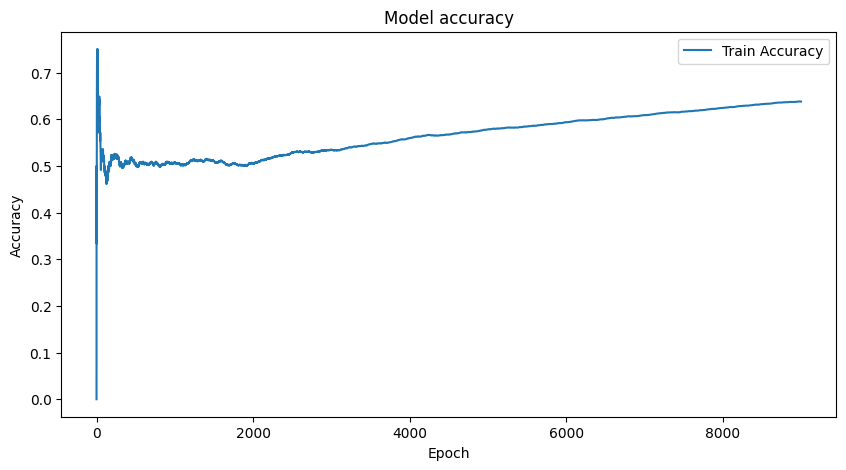

In [26]:
# Plot training & validation loss values
partacc=[]
for i in range(len(cumaccuracies)):
  partacc+=[sum(cumaccuracies[0:i])/(i+1)]
plt.figure(figsize=(10, 5))
plt.plot(partacc, label='Train Accuracy')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

The model is learning and was still learning at the end of the first epoch.

A test is done on 50 unseen pairs.

The test is done with a hard selection for xi1 and xi2.

In [29]:
testaccuracies=[]
testlosses=[]

for i in range(50):
  x1,x2=images_test[i],images_test[i+50]
  x1 = tf.convert_to_tensor(x1)
  x1 = tf.cast(x1 , dtype=tf.float32)
  x2 = tf.convert_to_tensor(x2)
  x2 = tf.cast(x2 , dtype=tf.float32)

  augmented_images_x1 = data_augmentation([x1])
  augmented_images_x2 = data_augmentation([x2])
  augmented_images_x1 = tf.convert_to_tensor(augmented_images_x1)
  augmented_images_x1 = tf.cast(augmented_images_x1 , dtype=tf.float32)
  augmented_images_x2 = tf.convert_to_tensor(augmented_images_x2)
  augmented_images_x2 = tf.cast(augmented_images_x2 , dtype=tf.float32)
  # Randomly stack augmented images
  p = np.random.binomial(1, 0.5)
  if p == 0:
      hat_x = ([augmented_images_x1[0], augmented_images_x2[0]])

  else:
      hat_x = ([augmented_images_x2[0], augmented_images_x1[0]])


  # Calculate true order p
  true_p = np.array([p], dtype=np.float32)
  true_p = tf.convert_to_tensor(true_p)
  # Train sender
  b_x = sender_model((tf.expand_dims(x1, axis=0),tf.expand_dims(x2, axis=0)))
  b_x = int(b_x>0.5) # Hard Selection
  b_x = tf.cast(tf.expand_dims(b_x, axis=-1), dtype=tf.float32)
  xi = emb_model(b_x)
  xi = tf.expand_dims(xi, axis=0)
  hat_p = rec_model((tf.expand_dims(hat_x[0],axis=0),tf.expand_dims(hat_x[1],axis=0), xi))

  loss = (hat_p-true_p)**2
  testlosses+=[float(tf.squeeze(loss))]
  predicted_p = int(tf.squeeze(hat_p) > 0.5)
  true_p = int(tf.squeeze(true_p))
  if predicted_p == true_p:
    testaccuracies += [1]
  else:
    testaccuracies += [0]

print("Accuracy on the test set" , sum(testaccuracies)/len(testaccuracies))

Accuracy on the test set 0.64


The accuracy is above the random guess. If more time was given for training, the accuracy on the test set should be better.

In [5]:
import random
import itertools
from tensorflow.keras.models import load_model
import json
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras import Model, losses
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

sender_model = load_model("send model")
emb_model = load_model("emb model")
rec_model = load_model("receiver model")

def load_from_json(file_path):
  # Load the data from the JSON file
  with open(file_path, 'r') as file:
    data = json.load(file)

  return data


save_path = '/content/my_data.json'

# Load the data back from the JSON file
loaded_data = load_from_json(save_path)

# Access the loaded data
cumaccuracies=loaded_data['cumaccuracies']  # Access the 'losses' list
cumlosses=loaded_data['cumlosses']

In [15]:
x1l=[]
x2l=[]
aix1l=[]
aix2l=[]
bxl=[]
pl=[]
hat_pl=[]

for i in range(10):
  x1,x2=images_test[i],images_test[i+50]
  x1l+=[x1]
  x2l+=[x2]
  x1 = tf.convert_to_tensor(x1)
  x1 = tf.cast(x1 , dtype=tf.float32)
  x2 = tf.convert_to_tensor(x2)
  x2 = tf.cast(x2 , dtype=tf.float32)

  augmented_images_x1 = data_augmentation([x1])
  augmented_images_x2 = data_augmentation([x2])
  aix1l+=[augmented_images_x1]
  aix2l+=[augmented_images_x2]

  augmented_images_x1 = tf.convert_to_tensor(augmented_images_x1)
  augmented_images_x1 = tf.cast(augmented_images_x1 , dtype=tf.float32)
  augmented_images_x2 = tf.convert_to_tensor(augmented_images_x2)
  augmented_images_x2 = tf.cast(augmented_images_x2 , dtype=tf.float32)
  # Randomly stack augmented images
  p = np.random.binomial(1, 0.5)
  if p == 0:
      hat_x = ([augmented_images_x1[0], augmented_images_x2[0]])

  else:
      hat_x = ([augmented_images_x2[0], augmented_images_x1[0]])
  pl+=[p]


  # Calculate true order p
  true_p = np.array([p], dtype=np.float32)
  true_p = tf.convert_to_tensor(true_p)
  # Train sender
  b_x = sender_model((tf.expand_dims(x1, axis=0),tf.expand_dims(x2, axis=0)))
  b_x = int(b_x>0.5) # Hard Selection
  b_x = tf.cast(tf.expand_dims(b_x, axis=-1), dtype=tf.float32)
  xi = emb_model(b_x)
  xi = tf.expand_dims(xi, axis=0)
  hat_p = rec_model((tf.expand_dims(hat_x[0],axis=0),tf.expand_dims(hat_x[1],axis=0), xi))
  bxl+=[b_x]

  xi = emb_model(b_x)
  hat_pl+=[hat_p]

  loss = (hat_p-true_p)**2




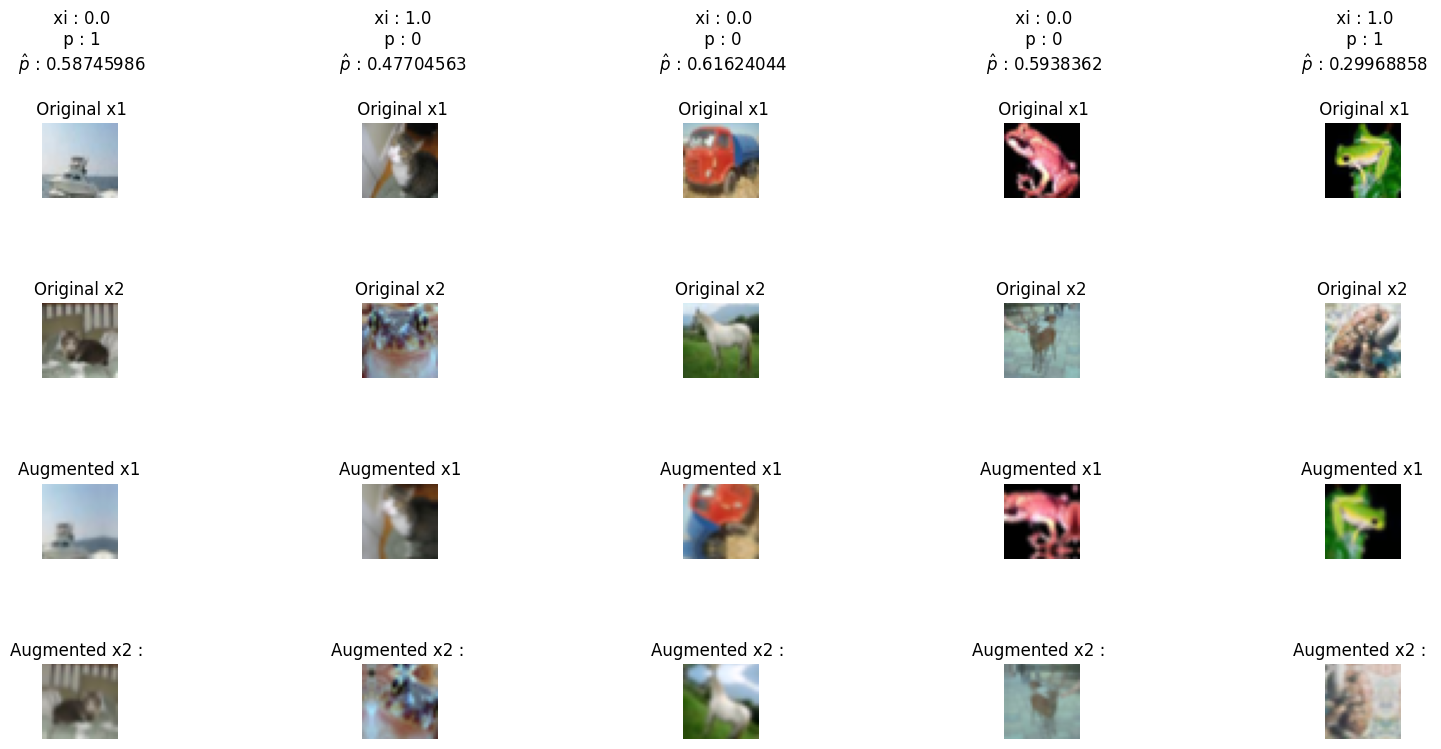

In [49]:
# Visualize the results
n = 5
plt.figure(figsize=(20, 8))
#image_size = 64
for i in range(n):
    # Display original
    ax = plt.subplot(7, n, i + 1)
    plt.imshow(x1l[i])
    title_str = (
    " xi : " + str(np.array(bxl[i])[0])
    + "\n p : "
    + str(np.array(pl[i]))
    + "\n $\hat{p}$ : "
    + str(np.array(hat_pl[i][0][0][0][0]))
    + "\n \n Original x1")
    plt.title(title_str)
    plt.axis('off')

    # Display original
    ax = plt.subplot(7, n, i + 1+2*n)
    plt.imshow(x2l[i])
    plt.title("Original x2")
    plt.axis('off')

    # Display
    ax = plt.subplot(7, n, i + 1 + 4*n)
    plt.imshow(aix1l[i][0])
    plt.title("Augmented x1")
    plt.axis('off')


    # Display
    ax = plt.subplot(7, n, i + 1 + 6*n)
    plt.imshow(aix2l[i][0])
    title_str = (
    "Augmented x2 : "
    )
    plt.title(title_str)
    plt.axis('off')

plt.show()

To check and avoid overfitting. The different models can be saved separetely during the training phase in a list every 1000 steps. The ones with the best generalization on the test set can be kept.

In [ ]:
"""
#during training
        if k%1000==0:
          sender_model_list+=[sender_model]
          emb_model_list+=[emb_model]
          rec_model_list+=[rec_model]

#then for the generalization tests
for i in range(len(sender_model_list):
  sender_model = sender_model_list[i]
  emb_model = emb_model_list[i]
  rec_model = rec_model_list[i]
"""